In [1]:
import os
import sys
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
from typing import Dict, List
import numpy as np
import math
import yaml

pp = PrettyPrinter(indent=4)
from barazmoon.twitter import twitter_workload_generator

# get an absolute path to the directory that contains parent files
__file__ = globals()["_dh"][0]
project_dir = __file__ = globals()["_dh"][0]
sys.path.append(os.path.normpath(os.path.join(project_dir, "..", "..", "..")))

from experiments.utils.constants import (
    FINAL_RESULTS_PATH,
    FIGURES_PATH,
    ACCURACIES_PATH,
)
from experiments.utils.parser import AdaptationParser
from experiments.utils.drawing import draw_temporal, draw_cumulative
import experiments.utils.drawing

In [2]:
metaserieses = [47, 47, 47, 47]
# serieses = [1, 2, 3, 4, 5]
serieses = [21, 22, 23, 25]


# sla = 6.89 # video
sla = 9.23 # audio-qa
# sla = 9.42 # audio-sent
# sla = 3.84 # sum-qa
# sla = 17.61 # nlp

# serie_color = {"IPA": "#ffff99", "FA2-low": "#a1dab4", "FA2-high": "#41b6c4", "RIM-high": "#253494"}
# yellow: ffff99

series_metadata = {
    21: {"label": "IPA", "color": "#d7191c"},
    22: {"label": "FA2-low", "color": "#a1dab4"},
    23: {"label": "FA2-high", "color": "#41b6c4"},
    # 44: {"label": "RIM-low", "color": ""},
    25: {"label": "RIM", "color": "#253494"},
}
pipeline_name = "audio-qa"

series_paths = {
    series: os.path.join(
        FINAL_RESULTS_PATH, "metaseries", str(metaseries), "series", str(series)
    )
    for series, metaseries in zip(serieses, metaserieses)
}

loaders = {
    series: AdaptationParser(
        series_path=series_path, model_name="video", type_of="router_pipeline"
    )
    for series, series_path in series_paths.items()
}

In [3]:
loaders

{21: <experiments.utils.parser.AdaptationParser at 0x7f71e86fd040>,
 22: <experiments.utils.parser.AdaptationParser at 0x7f71f2ba8070>,
 23: <experiments.utils.parser.AdaptationParser at 0x7f72b06b9ee0>,
 25: <experiments.utils.parser.AdaptationParser at 0x7f71e87161f0>}

In [4]:
accuracy_methods = {}
adaptation_intervals = {}
simulation_modes = {}
configs = {}
for series, loader in loaders.items():
    configs_exp = loader.load_configs()
    print(f"series: {series} config:\n")
    config = configs_exp["0.yaml"]
    pp.pprint(config)
    configs[series] = config
    accuracy_methods[series] = config["accuracy_method"]
    adaptation_intervals[series] = config["adaptation_interval"]
    simulation_modes[series] = config["simulation_mode"]

series: 21 config:

{   'accuracy_method': 'multiply',
    'adaptation_interval': 10,
    'allocation_mode': 'base',
    'alpha': 20,
    'backup_predictor_duration': 2,
    'backup_predictor_type': 'max',
    'baseline_mode': None,
    'batching_cap': 1,
    'benchmark_duration': 1,
    'beta': 0.5,
    'central_queue': True,
    'debug_mode': False,
    'distrpution_time': 30,
    'drop_limit': 20,
    'from_storage': [True, True],
    'gamma': 1e-06,
    'initial_active_model': [   'facebook-s2t-small-librispeech-asr',
                                'deepset-roberta-base-squad2'],
    'initial_batch': [1, 1],
    'initial_cpu_allocation': [1, 1],
    'initial_replica': [1, 1],
    'latency_margin': 100,
    'logs_enabled': False,
    'lowest_model_accuracy': 0.05,
    'metadata': 'bursty - ipa - cpu type: compute_cascadelake_r_ib - redo of '
                'metaseries bursty on chameleon to check latencies',
    'metaseries': 52,
    'mode': 'exponential',
    'model_name': ['audi

In [5]:
# load the sent workload
sent_loads = {}
for series, config in configs.items():
    workload_type = config["workload_type"]
    workload_config = config["workload_config"][0]
    start = workload_config["start"]
    end = workload_config["end"]
    damping_factor = workload_config["damping_factor"]
    sent_loads[series] = twitter_workload_generator(
        days=f"{start}-{end}", damping_factor=damping_factor
    )

In [6]:
# key_config_df = loader.loader.key_config_mapper()
# display(key_config_df)
# key_config_df.columns
results_all = []
simulation_modes

{21: False, 22: False, 23: False, 25: False}

In [7]:
adaptation_logs = dict(
    map(lambda l: (l[0], l[1].load_adaptation_log()), loaders.items())
)

In [8]:
series_changes = {}
for series in serieses:
    series_changes[series] = loaders[series].series_changes(
        adaptation_log=adaptation_logs[series]
    )

## Replica Changes
1. Total
2. Per node

In [9]:
replica_changes = {}
for series, series_dict in series_changes.items():
    # print(50 * "-" + f" {series} " + 50 * "-")
    replica_changes[series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        replica_changes[series][node_name] = metrics["replicas"]
        nodes.append(node_name)
    # replica_changes['total'] = []
    replica_changes[series]["total"] = [
        sum(x) for x in zip(*replica_changes[series].values())
    ]

## Per Container Core changes
1. Total
2. Per Node

In [10]:
core_changes = {}
for series in serieses:
    # print(50 * "-" + f" {series} " + 50 * "-")
    core_changes[series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        core_changes[series][node_name] = metrics["cpu"]
        nodes.append(node_name)
    core_changes[series]["total"] = [
        sum(x) for x in zip(*core_changes[series].values())
    ]

## Total core changes
replica * cores for each stage
1. Total
2. Per Node

In [11]:
total_core_changes = {}
for series in serieses:
    # print(50 * "-" + f" {series} " + 50 * "-")
    total_core_changes[series] = {}
    for key in replica_changes[series].keys():
        if key != "total":
            total_core_changes[series][key] = [
                x * y
                for x, y in zip(replica_changes[series][key], core_changes[series][key])
            ]
    total = np.zeros(len(list(total_core_changes[series].values())[0]))
    for key, series_value in total_core_changes[series].items():
        total += np.array(series_value)
    total_core_changes[series]["total"] = total.tolist()

ylabel = "Total Core"
print(total_core_changes)
print(total_core_changes.keys())

{21: {'audio': [1, 12, 12, 12, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 16, 16, 14, 16, 16, 16, 18, 16, 16, 16, 14, 18, 16, 14, 16, 16, 16, 18, 16, 18, 22, 23, 23, 24, 26, 25, 25, 26, 26, 26, 25, 25, 26, 26, 26, 26, 27, 26, 24, 22, 22, 22, 22, 22, 23, 22, 23, 23, 24, 24, 25, 21, 18, 18, 17, 12, 12, 12, 12, 13, 13, 28, 24, 24, 20, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16], 'nlp-qa': [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 6, 5, 5, 5, 4, 4, 4, 4, 4, 4, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 'total': [2.0, 14.0, 14.0, 14.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16

## Mapped Accuracy

In [12]:
# map accuracies
map_accuracy = True
with open(ACCURACIES_PATH, "r") as cf:
    accuracies = yaml.safe_load(cf)

# names_mapping = {"audio": "automatic-speech-recognition", "nlp-qa": "question-answering"}

for node_name, accuracy in accuracies[pipeline_name].items():
    if node_name == 'audio':
        for model, acc in accuracy.items():
            accuracies[pipeline_name][node_name][model] = 100 + acc
accuracies[pipeline_name]

{'audio': {'facebook-s2t-small-librispeech-asr': 58.72,
  'facebook-s2t-medium-librispeech-asr': 64.88,
  'facebook-s2t-large-librispeech-asr': 66.74000000000001},
 'nlp-qa': {'deepset-roberta-base-squad2': 82.9125,
  'deepset-xlm-roberta-base-squad2': 77.141}}

## Accuracy Changes

In [13]:
accuracy_changes = {}
for series in serieses:
    accuracy_changes[series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        if map_accuracy:
            accuracy_changes[series][node_name] = [
                accuracies[pipeline_name][node_name][variant] * 10 ** (-2)
                for variant in metrics["variant"]
            ]
        else:
            accuracy_changes[series][node_name] = metrics["accuracy"]
        nodes.append(node_name)
    if accuracy_methods[series] == "sum":
        accuracy_changes[series]["e2e"] = [
            sum(x) for x in zip(*accuracy_changes[series].values())
        ]
    elif accuracy_methods[series] == "multiply":
        accuracy_changes[series]["e2e"] = [
            math.prod(x) for x in zip(*accuracy_changes[series].values())
        ]
ylabel = "Accuracy"
print(accuracy_changes)
print(accuracy_changes.keys())

{21: {'audio': [0.5872, 0.6487999999999999, 0.6487999999999999, 0.6487999999999999, 0.6487999999999999, 0.6487999999999999, 0.6487999999999999, 0.6487999999999999, 0.6487999999999999, 0.6487999999999999, 0.6487999999999999, 0.6487999999999999, 0.6487999999999999, 0.6487999999999999, 0.6487999999999999, 0.6487999999999999, 0.6487999999999999, 0.6487999999999999, 0.6487999999999999, 0.6487999999999999, 0.6487999999999999, 0.6487999999999999, 0.6487999999999999, 0.6487999999999999, 0.6487999999999999, 0.6487999999999999, 0.6487999999999999, 0.6487999999999999, 0.6487999999999999, 0.6487999999999999, 0.6487999999999999, 0.6487999999999999, 0.6487999999999999, 0.6487999999999999, 0.6487999999999999, 0.6487999999999999, 0.6487999999999999, 0.6487999999999999, 0.6487999999999999, 0.5872, 0.5872, 0.5872, 0.5872, 0.5872, 0.5872, 0.5872, 0.5872, 0.5872, 0.5872, 0.5872, 0.5872, 0.5872, 0.5872, 0.5872, 0.5872, 0.5872, 0.5872, 0.5872, 0.5872, 0.5872, 0.5872, 0.5872, 0.5872, 0.5872, 0.5872, 0.5872, 

## Maeseured p99 Latency


In [14]:
timeout_per_second = {}
per_second_results = {}
for series in serieses:
    if not simulation_modes[series]:
        timeout_per_second[series], per_second_results[series] = loaders[
            series
        ].per_second_result_processing()
    else:
        timeout_per_second[series], per_second_results[series] = None, None

In [15]:
metric = "p99"  # [min, max, p99]
metrics_all = {}
for series in serieses:
    if not simulation_modes[series]:
        metric_columns = list(
            filter(lambda col: metric in col, per_second_results[series].columns)
        )
        metrics_all[series] = per_second_results[series][metric_columns]
        metrics_all[series] = metrics_all[series].to_dict(orient="list")
ylabel = "Second"
print(metrics_all)
print(metrics_all.keys())

{21: {'client_to_router_p99': [0.01505899429321289, 0.010100250244140624, 0.008898303508758545, 0.010952425003051759, 0.008767147064208985, 0.009957304000854492, 0.007153749465942383, 0.009849731922149657, 0.012223172187805175, 0.01040313720703125, 0.010023870468139648, 0.010060558319091797, 0.008639276027679443, 0.009604487419128418, 0.008791496753692627, 0.008971710205078125, 0.007888975143432618, 0.008663642406463624, 0.008114578723907471, 0.008452785015106202, 0.008796939849853516, 0.010106573104858399, 0.008397841453552246, 0.008533334732055664, 0.010719895362854004, 0.008357276916503906, 0.010247364044189453, 0.00856196403503418, 0.008597974777221679, 0.008774266242980958, 0.008939433097839355, 0.008356475830078125, 0.008838164806365966, 0.00785247802734375, 0.008506834506988525, 0.008345813751220703, 0.008668675422668456, 0.008808934688568115, 0.00810335397720337, 0.008235197067260742, 0.008235490322113037, 0.010230040550231934, 0.008341336250305175, 0.009287476539611816, 0.0112

## timeouts

In [16]:
ylabel = "% SLA Violations"
xlabel = "Experiments"
timeout_dics = {}
for series in serieses:
    if not simulation_modes[series]:
        timeout_dics[series] = {
            "e2e": (
                np.array(timeout_per_second[series]) / sum(sent_loads[series])
            ).tolist()
        }
        print(f"{sum(timeout_per_second[series])} out of {sum(sent_loads[series])}")

print(timeout_dics)
print(timeout_dics.keys())

183 out of 14437
309 out of 14437
227 out of 14437
0 out of 14437
{21: {'e2e': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00020779940430837432, 6.926646810279144e-05, 0.0001385329362055829, 0.0, 6.926646810279144e-05, 0.0, 0.0001385329362055829, 0.0001385329362055829, 0.0001385329362055829, 0.0, 6.926646810279144e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

# Paper ready figures

In [19]:
import importlib
import math


METRIC_TOTAL_CORE_CHANGES = "cost"
METRIC_ACCURACY_CHANGES = "accuracy"
# METRIC_MEASURED_LATENCY = "latency"
# METRIC_TIMEOUT_DICS = "sla_violation"
SLA_VIOLATION = "sla_violation"


metrics_metadata = {
    METRIC_TOTAL_CORE_CHANGES: {
        "title": "Cost",
        "ylabel": "Cost (cores)",
    },
    METRIC_ACCURACY_CHANGES: {
        "title": "Accuracy",
        "ylabel": "Accuracy",
        "ylim": (0.4, 0.55),
    },
    # METRIC_MEASURED_LATENCY: {
    #     "title": "Latency",
    #     "ylabel": "Latency (s)",
    # },
    SLA_VIOLATION: {
        "title": "SLA Violations",
        "ylabel": "SLA Violations (%)",
    },
}
results = {
    # METRIC_MEASURED_LATENCY: {},
    # METRIC_TIMEOUT_DICS: {},
    METRIC_TOTAL_CORE_CHANGES: {},
    METRIC_ACCURACY_CHANGES: {},
    SLA_VIOLATION: {},
}

# for serie in timeout_dics.keys():
#     sla_violations = list(filter(lambda x: x is not None and not math.isnan(x), timeout_dics[serie]["e2e"]))
#     results[METRIC_TIMEOUT_DICS][serie] = sum(sla_violations)/len(sla_violations)  # Fixme: Is this correct?

# for serie in metrics_all.keys():
#     latencies = list(
#         filter(
#             lambda x: x is not None and not math.isnan(x), metrics_all[serie]["e2e_p99"]
#         )
#     )
#     results[METRIC_MEASURED_LATENCY][serie] = sum(latencies) / len(latencies)

for serie in metrics_all.keys():
    latencies = list(
        filter(
            lambda x: x is not None and not math.isnan(x) and x > sla,
            metrics_all[serie]["e2e_p99"],
        )
    )
    results[SLA_VIOLATION][serie] = (
        len(latencies) / len(metrics_all[serie]["e2e_p99"]) * 100
    )

for serie in accuracy_changes.keys():
    results[METRIC_ACCURACY_CHANGES][serie] = sum(accuracy_changes[serie]["e2e"]) / len(
        accuracy_changes[serie]["e2e"]
    )

for serie in accuracy_changes.keys():
    results[METRIC_ACCURACY_CHANGES][serie] = sum(accuracy_changes[serie]["e2e"]) / len(
        accuracy_changes[serie]["e2e"]
    )

for serie in total_core_changes.keys():
    results[METRIC_TOTAL_CORE_CHANGES][serie] = sum(
        total_core_changes[serie]["total"]
    ) / len(total_core_changes[serie]["total"])


print(results)

{'cost': {21: 21.214876033057852, 22: 16.66115702479339, 23: 32.900826446280995, 25: 53.082644628099175}, 'accuracy': {21: 0.5197859999999991, 22: 0.45325203669421404, 23: 0.5379362999999988, 25: 0.5248511999999992}, 'sla_violation': {21: 3.166666666666667, 22: 0.0, 23: 7.833333333333334, 25: 0.0}}


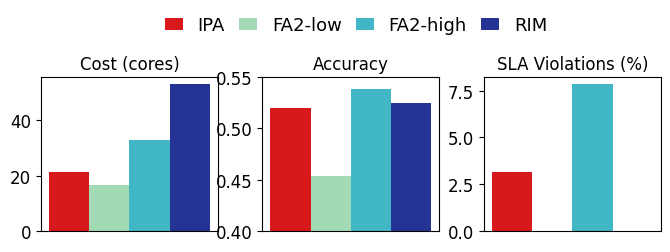

In [20]:
importlib.reload(experiments.utils.drawing)

experiments.utils.drawing.draw_cumulative_final(
    results,
    series_metadata,
    metrics_metadata,
    filename=f"{FIGURES_PATH}/metaseries-{metaserieses[0]}-{pipeline_name}-cul",
    bbox_to_anchor=(0.45, 1.5),
)